# Lymphocyte segmentation using logistic regression
Lymphocytes, a sub-type of white blood cells, are an important part of the immune system. Lymphocytic infiltration is the process by which the density of lymphocytes greatly increases at sites of disease or foreign bodies, indicating an immune response. A stronger immune response has been highly correlated to better outcomes in many forms of cancer, such as breast and ovarian.

Lymphocytes present with a blue tint from the absorption of hemotoxylin, their appearance similar in hue to nuclei, making them difficult to differentiate in some cases. Typically though, lymphocytes tend to be smaller, more chromatically dense, and circular.

## Logistic regression using pixel color values
The logistic regression model will use the color information of a pixel to classify whether or not that pixel belongs to a lymphocyte. The logistic regression assumes a linear relationship between the colors of the pixel and whether it belongs to a lymphocyte. However, The reality is probably much more complex.

In [1]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from skimage.io import imread, imshow
from skimage.segmentation import mark_boundaries, watershed
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from skimage.feature import peak_local_max
from skimage.morphology import opening, closing, disk

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from scipy.ndimage import distance_transform_edt, label

import seaborn as sns

### Dataset creation
The original dataset contains images from various organs and xml files showing nuclear boundary annotations. With the masks generated from the xml files it is possible to separate the image into lymphocytes and non-lymphocytes.

In [2]:
# It is assumed that the MoNuSAC dataset is in the MoNuSAC_images_and_annotations folder
# This folder should be placed in the working directory
# Similarly, the binary masks should be placed in the MoNuSAC_masks folder
im_path = Path("MoNuSAC_images_and_annotations/TCGA-E2-A154-01Z-00-DX1/TCGA-E2-A154-01Z-00-DX1_1.tif")

# The images are loaded as rgba but the a layer does not contain any information
# Only the first 3 layers are thus needed
im = imread(im_path, plugin='pil')[:, :, :3]

mask_path = Path("MoNuSAC_masks/TCGA-E2-A154-01Z-00-DX1/TCGA-E2-A154-01Z-00-DX1_1/Lymphocyte/268_mask.png")
mask = imread(mask_path)

Text(0.5, 1.0, 'mask')

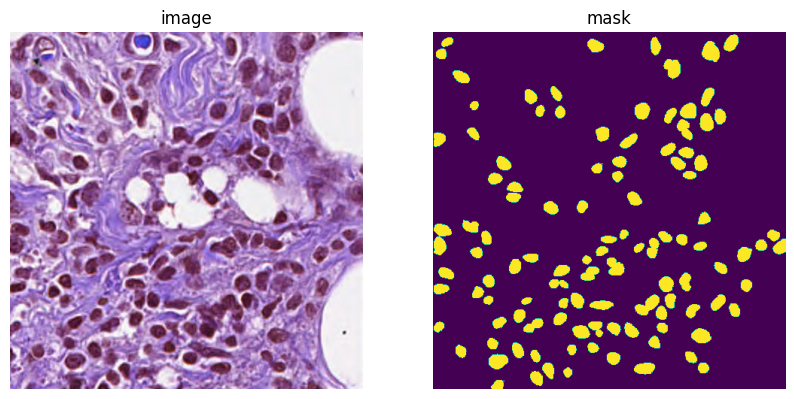

In [3]:
fig = plt.figure(figsize=(10, 7))

rows = 1
cols = 2

fig.add_subplot(rows, cols, 1)

plt.imshow(im)
plt.axis('off')
plt.title("image")


fig.add_subplot(rows, cols, 2)


plt.imshow(mask)
plt.axis('off')
plt.title("mask")

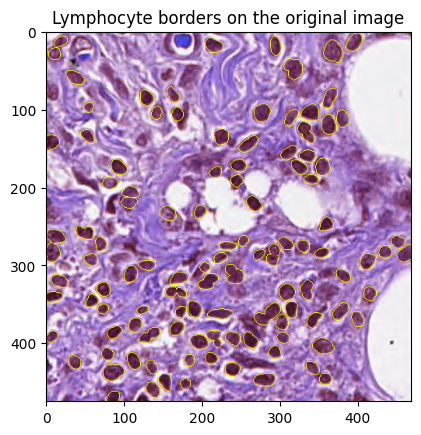

In [4]:
plt.figure()
plt.imshow(mark_boundaries(im, mask))
plt.title("Lymphocyte borders on the original image")
plt.show()

Lyphocyte and non-lymphocyte pixel color values are saved in dataframes to create a training and testing set for the logistic regression model

In [5]:
def mask_img2df(mask_path, im_path):
    """
    Save masked pixel color values and non-masked values in 2 different dataframes.
    """
    mask = imread(mask_path)
    im = imread(im_path, plugin='pil')[:, :, :3]
    # Get index of masked pixels
    index = np.nonzero(mask)
    # Save rgb pixel values in a datafram
    masked_im = im[index]
    df1 = pd.DataFrame(masked_im, columns=['R', 'G', 'B'])
    # Get index of non-masked pixels
    index = np.nonzero(mask==0)
    # Save rgb pixel values in a datafram
    masked_im = im[index]
    df2 = pd.DataFrame(masked_im, columns=['R', 'G', 'B'])
    return df1, df2


def img2df(im_path):
    """
    Save all image pixel color values in a dataframe.
    """
    im = imread(im_path, plugin='pil')[:, :, :3]

    r = im[:, :, 0].flatten()
    g = im[:, :, 1].flatten()
    b = im[:, :, 2].flatten()
    df1 = pd.DataFrame({'R':r, 'G':g, 'B':b})

    return df1


def recover_pixel_values(images_path, masks_path):
    """
    Go through image and mask folders to collect all pixel values.
    """
    df_positive = pd.DataFrame(columns=['R', 'G', 'B']) # dataframe for Lymphocyte pixel values
    df_negative = pd.DataFrame(columns=['R', 'G', 'B']) # dataframe for non-Lymphocyte pixel values

    # Loop through all images to recover the pixel values and store them in dataframes
    for patient in masks_path.glob("*"):
        patient_folder_mask = masks_path / patient.name
        patient_folder = images_path / patient.name
        
        for sub_image in patient_folder_mask.glob("*"):
            im_path = patient_folder/ (sub_image.name +".tif")
            # Check if a lymphocyte mask exist
            mask_folder = patient_folder_mask / sub_image.name / "Lymphocyte"
            mask_path = next(mask_folder.glob("*.png"), 0)
            # If the mask exists, save masked pixels as positive and others as negative
            if mask_path != 0:
                df1, df2 = mask_img2df(mask_path, im_path)
                df_positive = pd.concat([df_positive, df1])
                df_negative = pd.concat([df_negative, df2])
            # Otherwise, save all pixels as negative
            else:
                df1 = img2df(im_path)
                df_negative = pd.concat([df_negative, df1])
    return df_positive, df_negative

In [7]:
images_path = Path("MoNuSAC_images_and_annotations")
masks_path = Path("MoNuSAC_masks")

# Save lymphocyte and non-lymphocyte pixels in dataframes
df_positive, df_negative = recover_pixel_values(images_path, masks_path)

df_positive.to_csv('positive.csv', index=False)
df_negative.to_csv('negative.csv', index=False)


# Do the same thing for the test set
# The test set should be placed in the MoNuSAC_test folder
# The masks should be in the MoNuSAC_test_masks folder
# Both folder are assumed to be in the working directory
images_path = Path("MoNuSAC_test")
masks_path = Path("MoNuSAC_test_masks")

df_positive, df_negative = recover_pixel_values(images_path, masks_path)

df_positive.to_csv('positive_test.csv', index=False)
df_negative.to_csv('negative_test.csv', index=False)

In [11]:
df_positive = pd.read_csv('positive.csv')
df_negative = pd.read_csv('negative.csv')

# Add variable to indicate if the pixel belongs to a lymphocyte or not
df_negative['y'] = 0
df_positive['y'] = 1

# Combine both types into 1 dataframe
df = pd.concat([df_positive, df_negative]).reset_index(drop=True)

# Shuffle the dataframe
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

df.to_csv('train_total.csv', index=False)


# Do the same thing for the test set
df_positive = pd.read_csv('positive_test.csv')
df_negative = pd.read_csv('negative_test.csv')

# Add variable to indicate if the pixel belongs to a lymphocyte or not
df_negative['y'] = 0
df_positive['y'] = 1

# Combine both types into 1 dataframe
df = pd.concat([df_positive, df_negative]).reset_index(drop=True)

# Shuffle the dataframe
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

df.to_csv('test_total.csv', index=False)

As shown below, the dataset is highly unbalanced

<Axes: xlabel='y', ylabel='Count'>

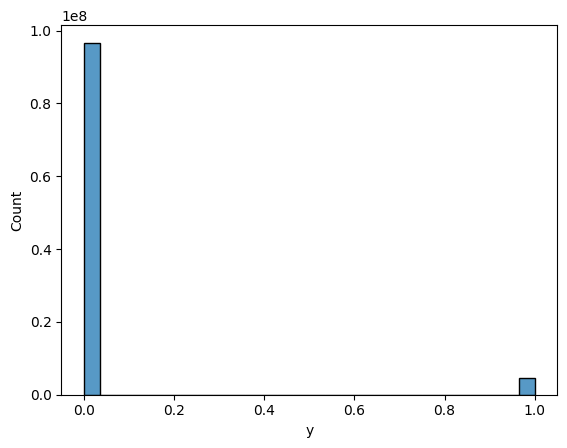

In [12]:
df = pd.read_csv('train_total.csv')
sns.histplot(data=df, x='y')

#### Model training and testing

In [13]:
def save_model(pkl_file, model):
    with open(pkl_file, 'wb') as f:
        pickle.dump(model, f)


def load_model(pkl_file):
    with open(pkl_file, 'rb') as f:
        model = pickle.load(f)
    return model

In [14]:
# Load training set
df_train = pd.read_csv('train_total.csv')
X_train = df_train.drop(['y'], axis=1)
y_train = df_train['y']

# Train the model
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

# Save the result
save_model("lr_model_total.pkl", model)

In [15]:
# Test the model on the test set
df_test = pd.read_csv('test_total.csv')
X_test = df_test.drop(['y'], axis=1)
y_test = df_test['y']

model = load_model("lr_model_total.pkl")
predictions = model.predict(X_test)

In [16]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98  35679525
           1       0.70      0.30      0.42   1732853

    accuracy                           0.96  37412378
   macro avg       0.83      0.65      0.70  37412378
weighted avg       0.95      0.96      0.95  37412378



In [17]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print((tn, fp, fn, tp))

(35451805, 227720, 1208692, 524161)


Seeing the results shown above, it seems clear that the model outputs a lot of false negatives. This is likely due to the highly unbalanced nature of the dataset. Indeed, the dataset is mostly made of negative pixels. As such, it makes sens that the model would have a strong bias towards the negative class.

#### Test the model on images

In [18]:
def find_lymphocyte(model, im):
    """
    Use the logistic regression model to create a binary mask showing lymphocyte positions.
    """
    # Flatten the image color planes and store them in a form similar to the training set
    r = im[:,:,0].flatten()
    g = im[:,:,1].flatten()
    b = im[:,:,2].flatten()
    df = pd.DataFrame({'R':r, 'G':g, 'B':b})

    # Predict if a pixel belongs to a Lymphocyte or not
    predictions = np.array(model.predict(df))

    # Use the prediction results to create a binary mask
    mask = predictions.reshape(im.shape[:2]).astype(bool)
    return mask

def IOU(pred_mask, gt_mask):
    """
    Compute the intersection over union between predicted and ground-truth binary masks.
    """
    intersection =  np.count_nonzero(pred_mask & gt_mask)
    union = np.count_nonzero(pred_mask | gt_mask)
    if union != 0:
        iou = intersection/union
    else:
        iou = 1
    return iou

In [21]:
im_path = Path('MoNuSAC_test/TCGA-2Z-A9JG-01Z-00-DX1/TCGA-2Z-A9JG-01Z-00-DX1_5.tif')
mask_path = Path('MoNuSAC_test_masks/TCGA-2Z-A9JG-01Z-00-DX1/TCGA-2Z-A9JG-01Z-00-DX1_5/Lymphocyte/22_mask.png')

im = imread(im_path, plugin='pil')[:, :, :3]
mask = imread(mask_path).astype(bool)
model = load_model("lr_model_total.pkl")
pred = find_lymphocyte(model, im)

The following pictures clearly shows that the model has a tendency to output a large number of false negatives. Many of the lymphocytes in the pictures are faded.

Text(0.5, 1.0, 'prediction')

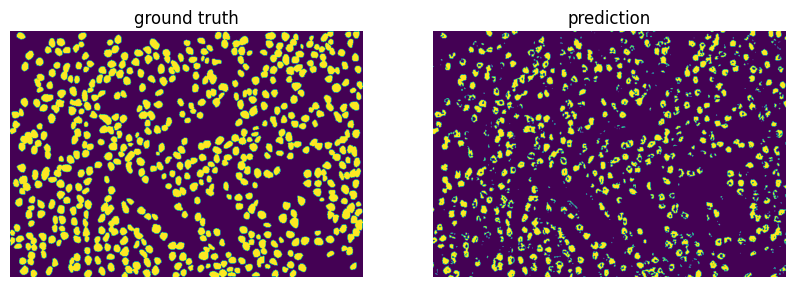

In [22]:
fig = plt.figure(figsize=(10,7))

rows = 1
cols = 2

fig.add_subplot(rows, cols, 1)

plt.imshow(mask)
plt.axis('off')
plt.title("ground truth")


fig.add_subplot(rows, cols, 2)


plt.imshow(pred)
plt.axis('off')
plt.title("prediction")

In [23]:
# Compute the IoU between both images
pred_mask = pred
gt_mask = mask

iou = IOU(pred_mask, gt_mask)
iou

0.4592025560806763

In [26]:
def test_model(images_path, masks_path, model):
    """
    Go through image and mask folders to test a model.
    """

    iou_lst = []
    # Loop through all images in the test set, apply the model, and compute the IOU
    for patient in masks_path.glob("*"):
        patient_folder_mask = masks_path / patient.name
        patient_folder = images_path / patient.name

        for sub_image in patient_folder_mask.glob("*"):
            # Read the image
            im_path = patient_folder/ (sub_image.name +".tif")
            im = imread(im_path, plugin='pil')[:, :, :3]
            mask_folder = patient_folder_mask / sub_image.name / "Lymphocyte"
            mask_path = next(mask_folder.glob("*.png"), 0)
            # Read the mask if it exists
            if mask_path != 0:
                mask = imread(mask_path).astype(bool)
            # Otherwise create a blank mask
            else:
                mask = np.zeros(im.shape[:2], dtype = bool)
            # Use the model and compute the iou
            res = find_lymphocyte(model, im)
            iou = IOU(res, mask)
            iou_lst.append(iou)
    return iou_lst

In [27]:
images_path = Path("MoNuSAC_test")
masks_path = Path("MoNuSAC_test_masks")

model = load_model('lr_model_total.pkl')

iou_lst = np.array(test_model(images_path, masks_path, model))

Many images to not contain lymphocytes, resulting in an IoU of 0 in a lot of cases. The average was thus computed with and without these images.

In [28]:
iou_lst

array([0.        , 0.        , 0.        , 0.        , 0.45920256,
       0.14836023, 0.46693454, 0.        , 0.        , 1.        ,
       0.24297857, 0.26305354, 0.51147578, 0.04113206, 0.05522925,
       0.0390625 , 0.05887944, 0.05882353, 0.06947891, 0.        ,
       0.02704247, 0.02696078, 0.10093882, 0.        , 0.05800986,
       0.40126913, 0.31380753, 0.31419045, 0.        , 0.        ,
       0.        , 0.60758145, 0.22281821, 0.        , 0.        ,
       0.        , 0.57064962, 0.00590717, 0.31710214, 0.        ,
       0.        , 0.25524415, 0.        , 0.43447851, 0.        ,
       0.06792587, 0.02912668, 0.04561541, 0.00342759, 0.        ,
       0.02285016, 0.09748744, 0.        , 0.        , 0.        ,
       0.03023256, 0.        , 0.14820042, 0.1239593 , 0.07923729,
       0.32895402, 0.        , 0.48317824, 0.        , 0.0896861 ,
       0.        , 0.58178587, 0.11237483, 0.14129919, 0.05792181,
       0.04826615, 0.        , 0.00450045, 0.08190946, 0.21747

In [29]:
sum(iou_lst)/len(iou_lst)

0.1259260547421742

In [31]:
sum(iou_lst[iou_lst!=0])/len(iou_lst[iou_lst!=0])

0.2009973566077011

### Balanced dataset creation
The training and testing sets are highly unbalanced. That is because most pixels in the image do not belong to a lymphocyte. To construct balanced training and testing sets, a number of negative samples equivalent to the number of positive samples is randomly chosen.

In [32]:
df_positive = pd.read_csv('positive.csv')
df_negative = pd.read_csv('negative.csv')

# Randomly sample a number of negative values to create balanced sets
# Combine positive and negative values to construct the training and testing sets
tmp = df_negative.sample(len(df_positive), ignore_index=True)
tmp['y'] = 0
df_positive['y'] = 1
df = pd.concat([df_positive, tmp]).reset_index(drop=True)

# Shuffle the dataframe
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

df.to_csv('train.csv', index=False)


# Do the same for the test set
df_positive = pd.read_csv('positive_test.csv')
df_negative = pd.read_csv('negative_test.csv')

# Randomly sample a number of negative values to create balanced sets
# Combine positive and negative values to construct the training and testing sets
tmp = df_negative.sample(len(df_positive), ignore_index=True)
tmp['y'] = 0
df_positive['y'] = 1
df = pd.concat([df_positive, tmp]).reset_index(drop=True)

# Shuffle the dataframe
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

df.to_csv('test.csv', index=False)

#### Model training and testing
The model can now be trained with the constructed sets

In [33]:
# Load training and testing sets
df_train = pd.read_csv('train.csv')
X_train = df_train.drop(['y'], axis=1)
y_train = df_train['y']

df_test = pd.read_csv('test.csv')
X_test = df_test.drop(['y'], axis=1)
y_test = df_test['y']

In [34]:
# train the model
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [35]:
# test the model
predictions = model.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88   1732853
           1       0.87      0.88      0.88   1732853

    accuracy                           0.88   3465706
   macro avg       0.88      0.88      0.88   3465706
weighted avg       0.88      0.88      0.88   3465706



In [36]:
# Compute the confusion matrix on the test set
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print((tn, fp, fn, tp))

(1515112, 217741, 214977, 1517876)


#### Test the model directly on images

In [37]:
im_path = "MoNuSAC_test/TCGA-2Z-A9JG-01Z-00-DX1/TCGA-2Z-A9JG-01Z-00-DX1_5.tif"
im = imread(im_path, plugin='pil')[:, :, :3]

mask_path = "MoNuSAC_test_masks/TCGA-2Z-A9JG-01Z-00-DX1/TCGA-2Z-A9JG-01Z-00-DX1_5/Lymphocyte/22_mask.png"
mask = imread(mask_path)

# Load the model
model = load_model('lr_model.pkl')
pred = find_lymphocyte(model, im)

Seeing the results shown below, it seems this model outputs many false positives. Indeed, Many pixels are classified as lymphocytes even thought that is not the case. The best model will thus depend on the type of error that is more acceptable. 

Furthermore, it might be interesting to isolate regions of interest using more classical computer vision techniques(e.g. watershed algorithm).

Text(0.5, 1.0, 'prediction')

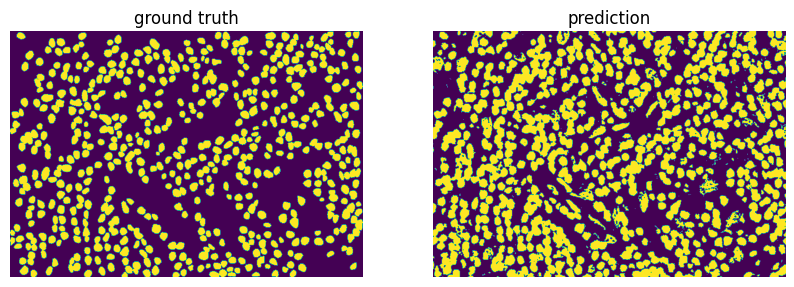

In [38]:
fig = plt.figure(figsize=(10,7))

rows = 1
cols = 2

fig.add_subplot(rows, cols, 1)

plt.imshow(mask)
plt.axis('off')
plt.title("ground truth")


fig.add_subplot(rows, cols, 2)


plt.imshow(pred)
plt.axis('off')
plt.title("prediction")

In [39]:
# Compute the IOU between both images
pred_mask = pred
gt_mask = mask

iou = IOU(pred_mask, gt_mask)
iou

0.6452035354618505

In [40]:
images_path = Path("MoNuSAC_test")
masks_path = Path("MoNuSAC_test_masks")

model = load_model('lr_model.pkl')

iou_lst = np.array(test_model(images_path, masks_path, model))

In [41]:
iou_lst

array([0.        , 0.        , 0.        , 0.        , 0.64520354,
       0.0246028 , 0.5975478 , 0.        , 0.        , 0.        ,
       0.08633494, 0.16385074, 0.41922853, 0.00823768, 0.00734557,
       0.00194429, 0.59730055, 0.14438064, 0.11521812, 0.        ,
       0.57960363, 0.03830819, 0.62137967, 0.        , 0.04293027,
       0.33017258, 0.06666667, 0.35254173, 0.        , 0.        ,
       0.        , 0.57113921, 0.02909945, 0.        , 0.        ,
       0.        , 0.61645268, 0.05187602, 0.0908842 , 0.        ,
       0.        , 0.03005375, 0.        , 0.65365384, 0.        ,
       0.07405098, 0.58597411, 0.62694188, 0.22142214, 0.        ,
       0.59223642, 0.00395471, 0.        , 0.        , 0.        ,
       0.17503587, 0.        , 0.02978147, 0.02874545, 0.04384772,
       0.29347496, 0.        , 0.40299205, 0.        , 0.0338594 ,
       0.        , 0.48435175, 0.00713133, 0.04477048, 0.65492531,
       0.67241468, 0.        , 0.16577221, 0.05057522, 0.66219

In [42]:
sum(iou_lst)/len(iou_lst)

0.1627816456542554

In [43]:
sum(iou_lst[iou_lst!=0])/len(iou_lst[iou_lst!=0])

0.2649191488098666

## Isolate regions of interest using the Watershed Algorithm
The watershed algorithm is a segmentation technique commonly used in computer vision and image processing to separate objects or regions within an image. It is particularly useful when dealing with images that contain overlapping or touching objects.

The algorithm is inspired by the concept of a physical watershed, where water flowing over a terrain eventually fills up basins and separates adjacent regions. Similarly, in the watershed algorithm, an image is treated as a topographic surface, where the intensity values of pixels represent the height of the surface.

Due to their particular shape and coloration, lymphocytes and nuclei can be isolated using the watershed algorithm.

In [44]:
def apply_watershed(image):
    """
    Use the watershed algorithm on color images.
    """
    # Convert the image to hed space
    hed_image = rgb2hed(image)

    # Threshold the image to get a binary image
    t = threshold_otsu(hed_image[:, :, 2])
    binary_image = hed_image[:, :, 2]>t

    # Use morphological operations to improve the mask
    mask = opening(closing(binary_image, disk(3)), disk(3))

    # Apply the distance transform and find the local maxima to use as markers for the watershed algorithm
    dist = distance_transform_edt(mask)
    coords = peak_local_max(dist, min_distance=7)
    tmp = np.zeros(dist.shape, dtype=bool)
    tmp[tuple(coords.T)] = True
    markers, _ = label(tmp)

    # Apply the watershed algorithm
    ws = watershed(-dist, markers, mask=mask)
    return ws

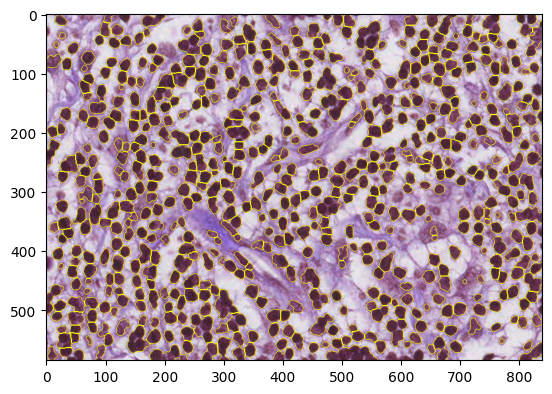

In [45]:
ws = apply_watershed(im)

plt.figure()
plt.imshow(mark_boundaries(im, ws))
plt.show()

The result is not perfect since there are still groupings of lymphocytes/nuclei that are considered as only one object. It is however not bad for such a simple method.

Once the regions of interest in the image have been segemented, it could be possible to further improve the result by removing certain regions based on size and shape. For now, this is not implemented.

## Watershed and logistic regression used concurently
Applying the model only on regions isolated by the watershed transform might improve the results obtained. Furthermore, a third model will be trained using only pixels from the regions of interest to see if it makes a difference.

### Build a dataset

In [46]:
def mask_img2df(mask_path, im_path):
    """
    Save masked pixel color values and non-masked values in 2 different dataframes.
    Negative pixels are only taken from regions selected by the watershed transform.
    """
    mask = imread(mask_path).astype(bool)
    im = imread(im_path, plugin='pil')[:, :, :3]

    # Save rgb pixel values in a datafram
    masked_im = im[mask]
    df1 = pd.DataFrame(masked_im, columns=['R', 'G', 'B'])

    # Apply watershed on the image
    ws_mask = apply_watershed(im).astype(bool)
    inter = ws_mask & np.invert(mask)
    # Save rgb pixel values in a datafram
    masked_im = im[inter]
    df2 = pd.DataFrame(masked_im, columns=['R', 'G', 'B'])
    return(df1, df2)


def img2df(im_path):
    """
    Save pixel color values from regions selected by the watershed in a dataframe.
    """
    im = imread(im_path, plugin='pil')[:,:,:3]
    # Apply watershed on the image
    ws_mask = apply_watershed(im).astype(bool)
    masked_im = im[ws_mask]

    df1 = pd.DataFrame(masked_im, columns=['R', 'G', 'B'])

    return df1

In [47]:
images_path = Path("MoNuSAC_images_and_annotations")
masks_path = Path("MoNuSAC_masks")

df_positive, df_negative = recover_pixel_values(images_path, masks_path)

df_positive.to_csv('positive_ws.csv', index=False)
df_negative.to_csv('negative_ws.csv', index=False)

In [48]:
df_positive = pd.read_csv('positive.csv')
df_negative = pd.read_csv('negative.csv')

df_negative['y'] = 0
df_positive['y'] = 1
df = pd.concat([df_positive, df_negative]).reset_index(drop=True)

# Shuffle the dataframe
df = df.sample(frac=1, random_state=3).reset_index(drop=True)

df.to_csv('train_ws.csv', index=False)

### Train the model

In [49]:
df = pd.read_csv('train_ws.csv')

X_train = df.drop(['y'], axis=1)
y_train = df['y']

In [50]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [51]:
save_model('lr_model_ws.pkl', model)

### Test the model on images
The model created with watershed as well as the 2 previous models will be tested.

In [52]:
def find_lymphocyte(model, im):
    """
    Use the trained model to predict if the regions labeled by the watershed transform belong to a lymphocyte or not.
    """
    # Apply the watershed algorithm
    ws = apply_watershed(im)
    # Create a mask for the result
    res = np.zeros(ws.shape, dtype = bool)
    # Loop through all regions identified by the watershed algorithm
    # and use the model to identify if the pixels belong to a lymphocyte or not
    for i in np.unique(ws):
        if i == 0:
            continue
        mask = ws == i
        pixel_values = im[mask]
        df = pd.DataFrame(pixel_values, columns=['R', 'G', 'B'])
        predictions = np.array(model.predict(df))
        res[mask] = predictions
    return res

In [55]:
im_path = Path("MoNuSAC_test/TCGA-2Z-A9JG-01Z-00-DX1/TCGA-2Z-A9JG-01Z-00-DX1_5.tif")
im = imread(im_path, plugin='pil')[:, :, :3]

mask_path = Path("MoNuSAC_test_masks/TCGA-2Z-A9JG-01Z-00-DX1/TCGA-2Z-A9JG-01Z-00-DX1_5/Lymphocyte/22_mask.png")
mask = imread(mask_path)

model = load_model('lr_model_ws.pkl')
pred = find_lymphocyte(model, im)

Text(0.5, 1.0, 'prediction')

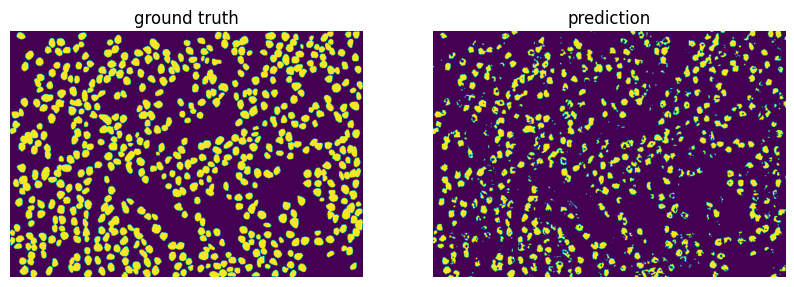

In [56]:
fig = plt.figure(figsize=(10,7))

rows = 1
cols = 2

fig.add_subplot(rows, cols, 1)
  
plt.imshow(mask)
plt.axis('off')
plt.title("ground truth")
  

fig.add_subplot(rows, cols, 2)


plt.imshow(pred)
plt.axis('off')
plt.title("prediction")

In [57]:
IOU(pred, mask)

0.4799334995843724

In [60]:
model1 = load_model('lr_model_total.pkl')  # Model trained on the whole dataset
model2 = load_model('lr_model.pkl')  # Model trained on a balanced dataset
model3 = load_model('lr_model_ws.pkl')  # Model trained with the output of the watershed algorithm

images_path = Path("MoNuSAC_test")
masks_path = Path("MoNuSAC_test_masks")

#### Model 1

In [61]:
iou_lst1 = np.array(test_model(images_path, masks_path, model1))

In [62]:
iou_lst1

array([0.        , 0.        , 0.        , 0.        , 0.45830161,
       0.14293221, 0.46609306, 0.        , 0.        , 1.        ,
       0.25713727, 0.26801347, 0.51595416, 0.04242331, 0.05623494,
       0.03965393, 0.05633468, 0.06481481, 0.06947891, 0.        ,
       0.02706252, 0.0269696 , 0.09976411, 0.        , 0.0581204 ,
       0.40126913, 0.31380753, 0.31629395, 0.        , 0.        ,
       0.        , 0.60655448, 0.22778807, 0.        , 0.        ,
       0.        , 0.565112  , 0.00596252, 0.31785714, 0.        ,
       0.        , 0.25907678, 0.        , 0.43556813, 0.        ,
       0.06950367, 0.02895211, 0.04385694, 0.00342759, 0.        ,
       0.02273861, 0.098778  , 0.        , 0.        , 0.        ,
       0.03023256, 0.        , 0.15827555, 0.12561786, 0.08461538,
       0.33282209, 0.        , 0.48387097, 0.        , 0.09188361,
       0.        , 0.59210526, 0.11581093, 0.16760405, 0.05047938,
       0.04566249, 0.        , 0.00462107, 0.08234461, 0.21530

In [64]:
sum(iou_lst1)/len(iou_lst1)

0.12693622936710933

In [65]:
sum(iou_lst1[iou_lst1!=0])/len(iou_lst1[iou_lst1!=0])

0.20260975072057835

#### Model 2

In [66]:
iou_lst2 = np.array(test_model(images_path, masks_path, model2))

In [67]:
iou_lst2

array([0.        , 0.        , 0.        , 0.        , 0.71569798,
       0.02217995, 0.71016237, 0.        , 0.        , 0.        ,
       0.1317781 , 0.23993441, 0.53444375, 0.00928338, 0.00830278,
       0.00207568, 0.61414453, 0.21648216, 0.12317551, 0.        ,
       0.60647507, 0.03957382, 0.65209595, 0.        , 0.04569955,
       0.40957447, 0.09701846, 0.39140276, 0.        , 0.        ,
       0.        , 0.69607108, 0.04412794, 0.        , 0.        ,
       0.        , 0.67752633, 0.08224852, 0.10877544, 0.        ,
       0.        , 0.03246313, 0.        , 0.71758859, 0.        ,
       0.07897606, 0.60405538, 0.63988572, 0.22641509, 0.        ,
       0.60026737, 0.00421567, 0.        , 0.        , 0.        ,
       0.19062748, 0.        , 0.03586711, 0.03193479, 0.06664652,
       0.40281442, 0.        , 0.46153846, 0.        , 0.05408015,
       0.        , 0.61476795, 0.00785126, 0.05733476, 0.6227348 ,
       0.66309929, 0.        , 0.18337731, 0.05651293, 0.67264

In [68]:
sum(iou_lst2)/len(iou_lst2)

0.1812481140636741

In [69]:
sum(iou_lst2[iou_lst2!=0])/len(iou_lst2[iou_lst2!=0])

0.2949724209271559

#### Model 3

In [70]:
iou_lst3 = np.array(test_model(images_path, masks_path, model3))

In [71]:
iou_lst3

array([0.        , 0.        , 0.        , 0.        , 0.4799335 ,
       0.11912226, 0.44989153, 0.        , 0.        , 1.        ,
       0.25024846, 0.26773855, 0.44491293, 0.04253962, 0.05626973,
       0.03608631, 0.03026727, 0.04273504, 0.06766917, 0.        ,
       0.01181599, 0.01272605, 0.0808973 , 0.        , 0.04946312,
       0.40376648, 0.34679335, 0.2786242 , 0.        , 0.        ,
       0.        , 0.53950059, 0.25801314, 0.        , 0.        ,
       0.        , 0.51923765, 0.00170358, 0.32199271, 0.        ,
       0.        , 0.26419837, 0.        , 0.42843671, 0.        ,
       0.07336737, 0.03341169, 0.03861058, 0.00257511, 0.        ,
       0.0090515 , 0.05269058, 0.        , 0.        , 0.        ,
       0.01680672, 0.        , 0.17101405, 0.12954592, 0.09184034,
       0.3125    , 0.        , 0.47484054, 0.        , 0.08965517,
       0.        , 0.56965899, 0.13089268, 0.16801075, 0.02998689,
       0.02940415, 0.        , 0.0055607 , 0.07362982, 0.16117

In [72]:
sum(iou_lst3)/len(iou_lst3)

0.1202694356608788

In [73]:
sum(iou_lst3[iou_lst3!=0])/len(iou_lst3[iou_lst3!=0])

0.19196852230486425

The watershed algorithm helped the second model the most. This makes sens since that model had a tendency output false positive. As such, limiting the search are improved its performance. 

This method left the performance of the first model pretty much unchanged. To improve the performance of the first model it might be interesting to use areas identified by the watershed algorithm to add to the output of the model. For example, if 50% of the pixel from a given label are identified by the model as being lymphocytes, then the whole item is selected. 

The third model unfortunately showed the worst performance.

In [6]:
def find_lymphocyte(model, im):
    """
    Use the trained model to predict if the regions labeled by the watershed transform belong to a lymphocyte or not.
    """
    # Apply the watershed algorithm
    ws = apply_watershed(im)
    # Create a mask for the result
    res = np.zeros(ws.shape, dtype = bool)
    # Loop through all regions identified by the watershed algorithm
    # and use the model to identify if the pixels belong to a lymphocyte or not
    for i in np.unique(ws):
        if i == 0:
            continue
        mask = ws == i
        pixel_values = im[mask]
        df = pd.DataFrame(pixel_values, columns=['R', 'G', 'B'])
        predictions = np.array(model.predict(df))
        # If more than 50% of an area is a lymphocyte, the whole area is kept
        if (sum(predictions) > (len(predictions)/2)):
            res[mask] = True
        else:
            res[mask] = predictions
    return res

In [7]:
model = load_model('lr_model_total.pkl')

images_path = Path("MoNuSAC_test")
masks_path = Path("MoNuSAC_test_masks")

iou_lst = np.array(test_model(images_path, masks_path, model))

In [10]:
iou_lst

array([0.        , 0.        , 0.        , 0.        , 0.53696301,
       0.14293221, 0.52884818, 0.        , 0.        , 1.        ,
       0.32816165, 0.34812388, 0.54974554, 0.04505428, 0.05477308,
       0.03965393, 0.05633468, 0.06481481, 0.06947891, 0.        ,
       0.02706252, 0.0269696 , 0.09976411, 0.        , 0.0581204 ,
       0.47086031, 0.41330645, 0.36664089, 0.        , 0.        ,
       0.        , 0.64653562, 0.27088419, 0.        , 0.        ,
       0.        , 0.62922115, 0.00459921, 0.36961451, 0.        ,
       0.        , 0.28853845, 0.        , 0.50742491, 0.        ,
       0.06885393, 0.02895211, 0.04560773, 0.00342759, 0.        ,
       0.023146  , 0.098778  , 0.        , 0.        , 0.        ,
       0.03023256, 0.        , 0.1760083 , 0.13578501, 0.0942813 ,
       0.39671564, 0.        , 0.47505543, 0.        , 0.06802721,
       0.        , 0.60833689, 0.13102596, 0.19886656, 0.05047938,
       0.04566249, 0.        , 0.00462107, 0.08234461, 0.22907

In [11]:
sum(iou_lst)/len(iou_lst)

0.13906675906540567

In [12]:
sum(iou_lst[iou_lst!=0])/len(iou_lst[iou_lst!=0])

0.22197194235439752